# Data Characterization: Chords
Tristan Miller, 9/16/2019

The goal of this notebook is to create a directory of all chord files, load them into a table, and do some basic characterization.

# Table of Contents

1. [Setup](#Setup)
1. [Chord file directory](#Chord-file-directory)
1. [Loading chords](#Loading-chords)
1. [Chord interpretation](#chord-interpretation)
1. [Characterization](#characterization)

# Setup
[Return to Table of Contents](#Table-of-Contents)

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import re

# Chord file directory
[Return to Table of Contents](#Table-of-Contents)

In [2]:
num_songs = 1108
song_directory = pd.DataFrame(data=np.zeros((num_songs,4)),columns=['dataset','artist','track','chord_filepath'])
song_directory['dataset'] = pd.Categorical(values = [np.nan]*num_songs,
                                           categories=['isophonics/The Beatles','isophonics/Queen',
                                                       'isophonics/Zweieck','mcgill'])

In [3]:
#first do isophonics
def get_iso_band(bandname,curr_row):
    """Fills out rows of the song directory for a band in the isophonics dataset.
    Returns next row number and number of rows filled out."""
    first_row = curr_row
    curr_dir = f'Data/Isophonics/{bandname} Annotations/chordlab/{bandname}'
    for r,d,f in os.walk('../'+curr_dir):
        for file in f:
            if '.lab' in file:
                song_directory.iloc[curr_row,:] = [f'isophonics/{bandname}',bandname,file[5:-4].replace('_',' '),
                                                      r[3:]+'/'+file]
                curr_row += 1
    return curr_row, (curr_row-first_row)

In [4]:
curr_row = 0
curr_row, num_beatles = get_iso_band('The Beatles',curr_row)
curr_row, num_queen = get_iso_band('Queen',curr_row)
curr_row, num_zweieck = get_iso_band('Zweieck',curr_row)

In [5]:
song_directory.iloc[215:220]

,dataset,artist,track,chord_filepath
215,isophonics/Zweieck,Zweieck,Spiel Mir Eine Alte Melodie,Data/Isophonics/Zweieck Annotations/chordlab/Z...
216,isophonics/Zweieck,Zweieck,Rawhide,Data/Isophonics/Zweieck Annotations/chordlab/Z...
217,isophonics/Zweieck,Zweieck,Jakob Und Marie,Data/Isophonics/Zweieck Annotations/chordlab/Z...
218,NaN,0,0,0
219,NaN,0,0,0


In [7]:
#next do mcgill billboard project
mcgill_index = pd.read_csv('../Data/McGill-Billboard/billboard-2.0-index.csv')

In [7]:
mcgill_index.head()

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN


In [8]:
curr_dir = 'Data/McGill-Billboard/'
first_row = curr_row
for i, row in mcgill_index.iterrows():
    if not pd.isna(row['title']):
        filepath = curr_dir + f'{row["id"]:04.0f}/full.lab'
        #print(filepath)
        song_directory.iloc[curr_row,:] = ['mcgill',row['artist'],row['title'],filepath]
        curr_row += 1
num_mcgill = curr_row - first_row

In [9]:
song_directory.tail()

,dataset,artist,track,chord_filepath
1103,mcgill,The Turtles,Happy Together,Data/McGill-Billboard/1290/full.lab
1104,mcgill,The Chiffons,He's So Fine,Data/McGill-Billboard/1292/full.lab
1105,mcgill,Billy Idol,White Wedding,Data/McGill-Billboard/1296/full.lab
1106,mcgill,The Everly Brothers,Ebony Eyes,Data/McGill-Billboard/1297/full.lab
1107,mcgill,Pet Shop Boys,Where The Streets Have No Name,Data/McGill-Billboard/1300/full.lab


Let's get rid of those annoying integers at the beginning of the titles of the white album


In [9]:
song_directory['track'].iloc[113:126] = song_directory['track'].iloc[113:126].apply(lambda x: x[5:])
song_directory['track'].iloc[71:88] = song_directory['track'].iloc[71:88].apply(lambda x: x[5:])

/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
#song_directory.to_csv('../song_directory.csv',index=False)

# Loading chords
[Return to Table of Contents](#Table-of-Contents)

In [10]:
song_directory = pd.read_csv('../song_directory.csv')

In [11]:
def get_chords(dataset_filter,sep):
    """Returns a dataframe with all chord data concatenated
    Only uses datasets that contain the dataset_filter string"""
    df = pd.DataFrame(columns=["start_time","end_time","chord"])
    for i, row in song_directory[song_directory.dataset.str.contains(dataset_filter)].iterrows():
        df = df.append(pd.read_csv(f"../{row['chord_filepath']}",sep=sep,
                     header=None,names=["start_time","end_time","chord"]),ignore_index=True)
    return df
        

In [12]:
df_beatles = get_chords('isophonics/The Beatles',' ')
df_queen = get_chords('isophonics/Queen','\t')
df_zweieck = get_chords('isophonics/Zweieck','\t')
df_mcgill = get_chords('mcgill','\t')
df_all = df_beatles.append(df_queen).append(df_zweieck).append(df_mcgill)

In [13]:
print('total number of chords:')
print(f'Beatles: {df_beatles.shape[0]}')
print(f'Queen: {df_queen.shape[0]}')
print(f'Zweieck: {df_zweieck.shape[0]}')
print(f'McGill: {df_mcgill.shape[0]}')
print(f'Total: {df_all.shape[0]}')

total number of chords:
Beatles: 14621
Queen: 2411
Zweieck: 1962
McGill: 124895
Total: 143889


In [14]:
print('number of unique chords:')
print(f'Beatles: {df_beatles.chord.unique().shape[0]}')
print(f'Queen: {df_queen.chord.unique().shape[0]}')
print(f'Zweieck: {df_zweieck.chord.unique().shape[0]}')
print(f'McGill: {df_mcgill.chord.unique().shape[0]}')
print(f'Total: {df_all.chord.unique().shape[0]}')

number of unique chords:
Beatles: 407
Queen: 189
Zweieck: 127
McGill: 976
Total: 1236


# Chord interpretation
[Return to Table of Contents](#Table-of-Contents)

In [343]:
#sample chord formats
df_all.chord.value_counts().sample(20)

B:min(11)/4       3
G:5(b7)           1
D:maj6(b7,11)     4
D:5(b7)          26
B:sus2            1
E:min/b7         97
C:maj7/3          2
G:sus2            2
F/7               2
F#:hdim7/b7       3
Cb:maj9           2
B:min7/5          5
F:maj9(*7)        1
F#:min(b13)       6
Db:maj/2         69
F/9               4
E:maj/b5          4
Ab:hdim7          3
Db:7/5            2
E:7(b13)/3        4
Name: chord, dtype: int64

Time for some regular expressions!  It looks intimidating and probably a bit overly complicated.  But it's just matching the following four groups:
- Root (e.g. F#)
- shorthand for chord quality(e.g. min, min, sus4, hdim7) (optional)
- added/removed notes (e.g. \*5,b7 means 5th removed, b7 added) (optional)
- Base (e.g. /3 means the bass plays the third) (optional)

In [16]:
matchstr = r'^([^:(\/]+):?([^(\/]+)?(?:\(([^)]+)\))?(?:\/(\S*))?$'

In [17]:
m = df_all['chord'].str.extract(matchstr)

In [18]:
#check that all chords matched
df_all.chord[pd.isna(m[0])]

Series([], Name: chord, dtype: object)

Here's my strategy for interpreting chords.  I'm not going to bother retaining all the information, and will instead retain the following:
1. Root (int format, C=0, Db=1,etc.; N=-1, X=nan)
1. Quality (unison, power, maj, min, dim, aug, sus)
1. Inversion (5 or 3, ignore all others)
1. Added interval (only most "important" interval given from this list: min7, 9, 6, maj7, 4, tt, min6, min9)

In [19]:
#define a function to get the root
root_to_num = {'Cb':11,'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'E#':5,'Fb':4,'F':5,'F#':6,'Gb':6,
              'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11,'B#':0,'N':-1,'X':np.nan}
#dict to put the root in readable format
num_to_root = {0:'C',1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B',-1:'~'}

def get_root(row):
    if row[1] == 'sus2':
        return (root_to_num[row[0]] + 7) % 12
    else:
        return root_to_num[row[0]]

In [38]:
#define a function to get chord quality (unison, power, maj, min, dim, aug, sus)
shorthand_to_quality = {'1':'unison',
                        '5':'power',
                        'maj':'maj','min':'min','dim':'dim','aug':'aug','sus4':'sus',
                        'sus2':'sus', #and change the root to the perfect 5th
                        '7':'maj','min7':'min','maj7':'maj','hdim7':'dim','dim7':'dim','minmaj7':'min',
                        'maj6':'maj','min6':'min',
                        'min9':'min','maj9':'maj','9':'maj',
                        '11':'maj','min11':'min','13':'maj','maj13':'maj','min13':'min'}

def get_quality(row):
    if row[1] in shorthand_to_quality:
        return shorthand_to_quality[row[1]]
    elif row[0] != 'N' and row[0] != 'X':
        #some chords just aren't labeled properly, but I think they're major chords.
        return 'maj'
    else:
        return np.nan

In [21]:
#define function to get inversion
def simplify_inversion(row):
    if row[1] == 'sus2':
        return np.nan
    if row[3] in ['5','b5','#5','#4']:
        return '5'
    if row[3] in ['3','b3','b4']:
        return '3'
    else:
        return np.nan

In [22]:
#I want to create a column with the single most relevant added interval
#first prioritizing info implied by the shorthand, with 13=6 > 11=4 > 2=9 > 7
#second prioritizing the last interval listed among the added intervals
shorthand_to_add = {'1':'',
                    '5':'',
                    'maj':'','min':'','dim':'','aug':'','sus4':'',#'sus2':'',
                    '7':'min7','min7':'min7','maj7':'maj7','hdim7':'min7','dim7':'6','minmaj7':'maj7',
                    'maj6':'6','min6':'6',
                    'min9':'9','maj9':'9','9':'9',
                    '11':'4','min11':'4','13':'6','maj13':'6','min13':'6'}

interval_to_add = {'7':'maj7',
                   'b7':'min7','#6':'min7',
                   '9':'9','2':'9',
                   'b9':'min9','b2':'min9',
                    '11':'4','4':'4',
                  '#11':'tt','#4':'tt','b5':'tt',
                  '13':'6','6':'6',
                   'b13':'min6','b6':'min6','#5':'min6'}

def get_add(row):
    if row[1] not in shorthand_to_add:
        return np.nan
    out = shorthand_to_add[row[1]]
    if out:
        return out
    if not row[2]:
        return np.nan
    interval = str(row[2]).split(',')[-1]
    if interval not in interval_to_add:
        return np.nan
    else:
        return interval_to_add[interval]

In [39]:
df_all['root'] = m.apply(lambda x: get_root(x),axis=1)
df_all['quality'] = m.apply(lambda x: get_quality(x),axis=1)
df_all['inversion'] = m.apply(lambda x: simplify_inversion(x),axis=1)
df_all['add'] = m.apply(lambda x: get_add(x),axis=1)

In [416]:
df_all.sample(20)

,start_time,end_time,chord,root,quality,inversion,add
58055,3.160723,4.005317,Ab:5,8.0,power,NaN,NaN
4875,132.418384,132.882531,A:sus4,9.0,sus,NaN,NaN
56729,134.783333,135.793243,B:1/1,11.0,unison,NaN,NaN
38398,199.266156,201.318141,Eb:maj,3.0,maj,NaN,NaN
109584,267.317021,269.497153,A:maj,9.0,maj,NaN,NaN
15666,162.592630,165.501973,A:maj,9.0,maj,NaN,NaN
94195,29.679790,31.287004,G#:min,8.0,min,NaN,NaN
109883,85.250476,86.026820,Bb:maj,10.0,maj,NaN,NaN
24619,168.005488,170.003492,D:min7,2.0,min,NaN,min7
74004,176.906213,179.432812,F:min,5.0,min,NaN,NaN


Okay, now I'm satisfied with this procedure, and will transfer it over to a .py file.

`chord_loader.py`

ETA: I later renamed and reworked this model, so this code will no longer work

In [27]:
#quick test that it works
sys.path.append('..')
import chord_loader
chord_loader.chord_simplify(df_beatles)
df_beatles.sample(10)

,start_time,end_time,chord,root,quality,add,inversion
7359,33.698526,36.821609,A,9,NaN,NaN,NaN
11892,101.222154,103.184240,A,9,NaN,NaN,NaN
2060,58.382831,61.157616,A,9,NaN,NaN,NaN
2925,105.352186,106.350644,E,4,NaN,NaN,NaN
9629,2.163680,4.001851,D/5,2,NaN,NaN,5
10816,138.687551,139.767278,A,9,NaN,NaN,NaN
11758,66.311114,67.274742,G,7,NaN,NaN,NaN
13557,24.282834,25.734081,C#:min,1,min,NaN,NaN
11813,123.176783,124.987939,C,0,NaN,NaN,NaN
12834,120.692086,122.004013,Bb,10,NaN,NaN,NaN


In [28]:
df_beatles.head(10)

,start_time,end_time,chord,root,quality,add,inversion
0,0.000000,0.459543,N,-1,NaN,NaN,NaN
1,0.459543,1.340333,E:min,4,min,NaN,NaN
2,1.340333,2.278566,A,9,NaN,NaN,NaN
3,2.278566,2.948732,E:min,4,min,NaN,NaN
4,2.948732,3.389127,A,9,NaN,NaN,NaN
5,3.389127,4.102040,G,7,NaN,NaN,NaN
6,4.102040,5.007619,E:min,4,min,NaN,NaN
7,5.007619,5.878367,A,9,NaN,NaN,NaN
8,5.878367,6.586576,E:min,4,min,NaN,NaN
9,6.586576,7.062585,A,9,NaN,NaN,NaN


In [29]:
df_all.chord[pd.isna(m[1])]

0         N
2         A
4         A
5         G
7         A
         ..
124750    N
124751    N
124752    N
124753    N
124894    N
Name: chord, Length: 16928, dtype: object

# Characterization
[Return to Table of Contents](#Table-of-Contents)

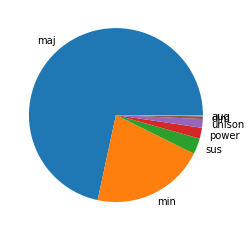

In [30]:
quality_counts = df_all.quality.value_counts(dropna=False)
plt.pie(quality_counts,labels=quality_counts.index);

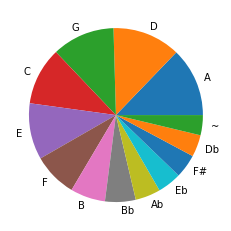

In [31]:
root_counts = df_all.root.value_counts(dropna=True)
plt.pie(root_counts,labels=[num_to_root[x] for x in root_counts.index]);

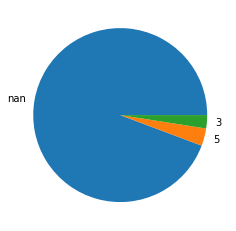

In [32]:
inv_counts = df_all.inversion.value_counts(dropna=False)
plt.pie(inv_counts,labels=inv_counts.index);

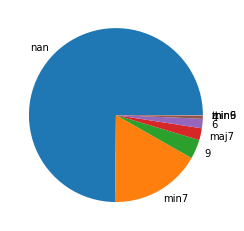

In [33]:
add_counts = df_all['add'].value_counts(dropna=False)
plt.pie(add_counts,labels=add_counts.index);

Based on the pie charts, the difficulty of classifying different aspects of the chords goes in the following order:
1. root
1. quality
1. add (min7, 9, maj7, 6 only)
1. inversion
1. other add

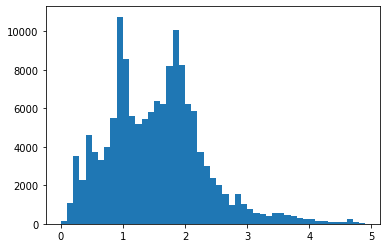

In [58]:
chord_length = df_all['end_time']-df_all['start_time']
length_hist = plt.hist(chord_length,bins=np.arange(0,5,.1));

0.13044056315951522


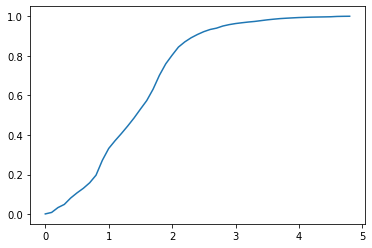

In [73]:
length_cumsum = np.cumsum(length_hist[0])/np.sum(length_hist[0])
plt.plot(np.arange(0,4.9,.1),length_cumsum);
print(length_cumsum[6])

## Better figures

In [49]:
sys.path.append('..')
import chord_loader

In [50]:
valid_directory = song_directory.loc[~pd.isna(song_directory['mp3_filepath'])]

In [51]:
#just get chords
all_labels = np.ndarray((0,4))
for i, row in valid_directory.iterrows():
    if row.dataset == 'isophonics/The Beatles':
        sep = ' '
    else:
        sep = '\t'
    song_labels = chord_loader.get_labels('../'+row.chord_filepath,sep,0.5)
    all_labels = np.concatenate((all_labels,song_labels),axis=0)

In [68]:
all_labels.shape

(338736, 4)

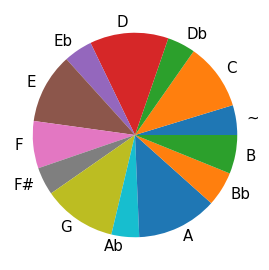

In [74]:
root_unique, root_counts = np.unique(all_labels[:,0], return_counts=True)
root_counts = root_counts[~np.isnan(root_unique)]
roots = [chord_loader.num_to_root[x] for x in root_unique[~np.isnan(root_unique)]]
plt.pie(root_counts,labels=roots)
plt.tight_layout()
plt.rc('font', size=20)
plt.savefig('images/pie_root')

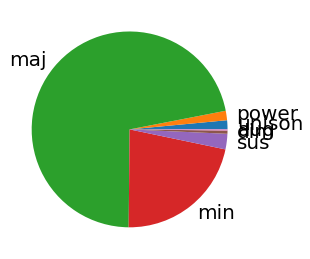

In [72]:
quality_unique, quality_counts = np.unique(all_labels[:,1], return_counts=True)
quality_counts = quality_counts[~np.isnan(quality_unique)]
qualities = [chord_loader.num_to_quality[x] for x in quality_unique[~np.isnan(quality_unique)]]
plt.pie(quality_counts,labels=qualities)
plt.tight_layout()
plt.rc('font', size=15)
plt.savefig('images/pie_quality')

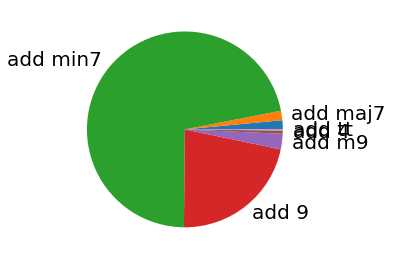

In [75]:
add_unique, add_counts = np.unique(all_labels[:,1], return_counts=True)
add_counts = add_counts[~np.isnan(add_unique)]
adds = [chord_loader.num_to_add[x] for x in add_unique[~np.isnan(add_unique)]]
plt.pie(add_counts,labels=adds)
plt.tight_layout()
plt.rc('font', size=15)
plt.savefig('images/pie_add')

In [76]:
inv_unique, inv_counts = np.unique(all_labels[:,1], return_counts=True)
inv_counts = inv_counts[~np.isnan(inv_unique)]
invs = [chord_loader.num_to_inv[x] for x in inv_unique[~np.isnan(inv_unique)]]
plt.pie(inv_counts,labels=invs)
plt.tight_layout()
plt.rc('font', size=15)
plt.savefig('images/pie_inv')

KeyError: 3.0